## DSCC202-402 Data Science at Scale Final Project
### Tracking Tweet sentiment at scale using a pretrained transformer (classifier)
<p>Consider the following illustration of the end to end system that you will be building.  Each student should do their own work.  The project will demonstrate your understanding of Spark Streaming, the medalion data architecture using Delta Lake, Spark Inference at Scale using an MLflow packaged model as well as Exploritory Data Analysis and System Tracking and Monitoring.</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/pipeline.drawio.png">

<p>
You will be pulling an updated copy of the course GitHub repositiory: <a href="https://github.com/lpalum/dscc202-402-spring2024">The Repo</a>.  If you are unclear on how to pull an updated copy using the GitHub command line, the following <a href="https://techwritingmatters.com/how-to-update-your-forked-repository-on-github">document</a> is helpful.  Be sure to add the professors and TAs as collaborators on your project. 

- lpalum@gmail.com GitHub ID: lpalum
- ajay.anand@rochester.edu GitHub ID: ajayan12
- divyamunot1999@gmail.com GitHub ID: divyamunot
- ylong6@u.Rochester.edu GitHub ID: NinaLong2077

Once you have updates your fork of the repository you should see the following template project that is resident in the final_project directory.
</p>

<img src="https://data-science-at-scale.s3.amazonaws.com/images/notebooks.drawio.png">

<p>
You can then pull your project into the Databrick Workspace using the <a href="https://www.databricks.training/step-by-step/importing-courseware-from-github/index.html">Repos</a> feature.
Each student is expected to submit the URL of their project on GitHub with their code checked in on the main/master branch.  This illustration highlights the branching scheme that you may use to work on your code in steps and then merge your submission into your master branch before submitting.
</p>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/github.drawio.png">
<p>
Work your way through this notebook which will give you the steps required to submit a complete and compliant project.  The following illustration and associated data dictionary specifies the transformations and data that you are to generate for each step in the medallion pipeline.
</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/dataframes.drawio.png">

#### Bronze Data - raw ingest
- date - string in the source json
- user - string in the source json
- text - tweet string in the source json
- sentiment - the given sentiment of the text as determined by an unknown model that is provided in the source json
- source_file - the path of the source json file the this row of data was read from
- processing_time - a timestamp of when you read this row from the source json

#### Silver Data - Bronze Preprocessing
- timestamp - convert date string in the bronze data to a timestamp
- mention - every @username mentioned in the text string in the bronze data gets a row in this silver data table.
- cleaned_text - the bronze text data with the mentions (@username) removed.
- sentiment - the given sentiment that was associated with the text in the bronze table.

#### Gold Data - Silver Table Inference
- timestamp - the timestamp from the silver data table rows
- mention - the mention from the silver data table rows
- cleaned_text - the cleaned_text from the silver data table rows
- sentiment - the given sentiment from the silver data table rows
- predicted_score - score out of 100 from the Hugging Face Sentiment Transformer
- predicted_sentiment - string representation of the sentiment
- sentiment_id - 0 for negative and 1 for postive associated with the given sentiment
- predicted_sentiment_id - 0 for negative and 1 for positive assocaited with the Hugging Face Sentiment Transformer

#### Application Data - Gold Table Aggregation
- min_timestamp - the oldest timestamp on a given mention (@username)
- max_timestamp - the newest timestamp on a given mention (@username)
- mention - the user (@username) that this row pertains to.
- negative - total negative tweets directed at this mention (@username)
- neutral - total neutral tweets directed at this mention (@username)
- positive - total positive tweets directed at this mention (@username)

When you are designing your approach, one of the main decisions that you will need to make is how you are going to orchestrate the streaming data processing in your pipeline.  There are several valid approaches.  First, you may choose to start the bronze_stream and let it complete (read and append all of the source data) before preceeding and starting up the silver_stream.  This approach has latency associated with it but it will allow your code to proceed in a linear fashion and process all the data by the end of your notebook execution.  Another potential approach is to start all the streams and have a "watch" method to determine when the pipeline has processed sufficient or all of the source data before stopping and displaying results.  Both of these approaches are valid and have different implications on how you will trigger your steams and how you will gate the execution of your pipeline.  Think through how you want to proceed and ask questions if you need guidance. The following references may be helpful:
- [Spark Structured Streaming Programming Guide](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html)
- [Databricks Autoloader - Cloudfiles](https://docs.databricks.com/en/ingestion/auto-loader/index.html)

### Be sure that your project runs end to end when *Run all* is executued on this notebook! (15 Points out of 60)

In [0]:
%run ./includes/includes

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
petastorm 0.11.4 requires pyspark>=2.1.0, which is not installed.


Variable Name,Value,Description
TWEET_BUCKET_NAME,voc-75-databricks-data,AWS S3 Bucket Name where the tweets are coming into your system.
TWEET_BUCKET_URL,https://voc-75-databricks-data.s3.amazonaws.com/,AWS S3 Bucket URL where the tweets are coming into your system.
TWEET_SOURCE_PATH,s3a://voc-75-databricks-data/voc_volume/,AWS S3 Path where the tweets are coming into your system.
USER_DIR,/tmp/labuser104917-3134916/,Path to the local storage (dbfs) for your project.
BRONZE_CHECKPOINT,/tmp/labuser104917-3134916/bronze.checkpoint,Store your Bronze Checkpoint data here.
BRONZE_DELTA,/tmp/labuser104917-3134916/bronze.delta,Store your Bronze Delta Table here.
SILVER_CHECKPOINT,/tmp/labuser104917-3134916/silver.checkpoint,Store your Silver Checkpoint data here.
SILVER_DELTA,/tmp/labuser104917-3134916/silver.delta,Store your Silver Delta Table here.
GOLD_CHECKPOINT,/tmp/labuser104917-3134916/gold.checkpoint,Store your Gold Checkpoint data here.
GOLD_DELTA,/tmp/labuser104917-3134916/gold.delta,Store your Gold Delta Table here.


the includes are included


In [0]:
"""
Adding a widget to the notebook to control the clearing of a previous run.
or stopping the active streams using routines defined in the utilities notebook
"""
dbutils.widgets.removeAll()

dbutils.widgets.dropdown("clear_previous_run", "No", ["No","Yes"])
if (getArgument("clear_previous_run") == "Yes"):
    clear_previous_run()
    print("Cleared all previous data.")

dbutils.widgets.dropdown("stop_streams", "No", ["No","Yes"])
if (getArgument("stop_streams") == "Yes"):
    stop_all_streams()
    print("Stopped all active streams.")

from delta import *
dbutils.widgets.dropdown("optimize_tables", "No", ["No","Yes"])
if (getArgument("optimize_tables") == "Yes"):
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, BRONZE_DELTA).optimize().executeCompaction()
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, SILVER_DELTA).optimize().executeCompaction()
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, GOLD_DELTA).optimize().executeCompaction()
    print("Optimized all of the Delta Tables")

Stopped all active streams.


## 1.0 Import your libraries here...
- Are your shuffle partitions consistent with your cluster and your workload?
- Do you have the necessary libraries to perform the required operations in the pipeline/application?

In [0]:
# ENTER YOUR CODE HERE



## 2.0 Use the utility functions to ...
- Read the source file directory listing
- Count the source files (how many are there?)
- print the contents of one of the files

In [0]:
# ENTER YOUR CODE HERE

from pyspark.sql import SparkSession
import pandas as pd

# Initialize Spark Session
spark = SparkSession.builder.appName("TweetSentimentAnalysis").getOrCreate()

# Get source listing DataFrame
source_df = get_source_listing_df()

# Count source files
num_files = len(source_df)

print(f"Number of files in source directory: {num_files}")

# Optional: Print contents of a file
if num_files > 0:
    file_to_display = source_df.iloc[0]['File Name']  # Assuming you want to display the first file
    file_contents = show_s3_file_contents(file_to_display)
    print(file_contents)


Number of files in source directory: 200001
b'{"date": "Mon Apr 06 22:19:45 PDT 2009", "user": "_TheSpecialOne_", "text": "@switchfoot http://twitpic.com/2y1zl - Awww, that\'s a bummer.  You shoulda got David Carr of Third Day to do it. ;D", "sentiment": "negative"}'


## 3.0 Transform the Raw Data to Bronze Data using a stream
- define the schema for the raw data
- setup a read stream using cloudfiles and the source data format
- setup a write stream using cloudfiles to append to the bronze delta table
- enforce schema
- allow a new schema to be merged into the bronze delta table
- Use the defined BRONZE_CHECKPOINT and BRONZE_DELTA paths defines in the includes
- name your raw to bronze stream as bronze_stream
- transform the raw data to the bronze data using the data definition at the top of the notebook

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, current_timestamp
import os

# Create a Spark session
spark = SparkSession.builder \
    .appName("TweetSentimentAnalysisStreaming") \
    .getOrCreate()

# Define the schema for the raw data
raw_schema = "date STRING, user STRING, text STRING, sentiment STRING"

# Create a streaming DataFrame using readStream
raw_stream_df = spark.readStream \
    .schema(raw_schema) \
    .json(TWEET_SOURCE_PATH)

# Define the transformation function for the stream
def transform_raw(df):
    # Get the source file path from the TWEET_SOURCE_PATH variable
    source_file = os.path.basename(TWEET_SOURCE_PATH)
    return df.withColumn("source_file", lit(source_file)) \
             .withColumn("processing_time", current_timestamp())

# Apply transformation to the streaming DataFrame
transformed_stream_df = transform_raw(raw_stream_df)



In [0]:
# Write the transformed streaming DataFrame to the Bronze Delta table using writeStream
query = transformed_stream_df.writeStream \
    .format("delta") \
    .option("checkpointLocation", BRONZE_CHECKPOINT) \
    .outputMode("append") \
    .start(BRONZE_DELTA)




In [0]:
# # Start the streaming query
# query.awaitTermination()

## 4.0 Bronze Data Exploratory Data Analysis
- How many tweets are captured in your Bronze Table?
- Are there any columns that contain Nan or Null values?  If so how many and what will you do in your silver transforms to address this?
- Count the number of tweets by each unique user handle and sort the data by descending count.
- How many tweets have at least one mention (@) how many tweet have no mentions (@)
- Plot a bar chart that shows the top 20 tweeters (users)


Number of tweets in Bronze Table: 200000
+----+----+----+---------+
|date|user|text|sentiment|
+----+----+----+---------+
|   0|   0|   0|        0|
+----+----+----+---------+

+---------------+-----+
|           user|count|
+---------------+-----+
|       tweetpet|  310|
|     nuttychris|  129|
|      iHomeTech|   81|
|       tsarnick|   77|
| Hollywood_Trey|   71|
|  divxdownloads|   68|
|      lesley007|   65|
|  redrobinrockn|   58|
|    MissxMarisa|   57|
|     SarahSaner|   56|
|     sebby_peek|   55|
|        kasey79|   54|
|torilovesbradie|   51|
|    whitsundays|   51|
|         keza34|   49|
| MiDesfileNegro|   48|
|        Dogbook|   47|
|   TraceyHewins|   46|
|    effingcards|   43|
|         Djalfy|   43|
+---------------+-----+
only showing top 20 rows

+--------------------+------------------+
|tweets_with_mentions|tweets_no_mentions|
+--------------------+------------------+
|               93817|            106183|
+--------------------+------------------+



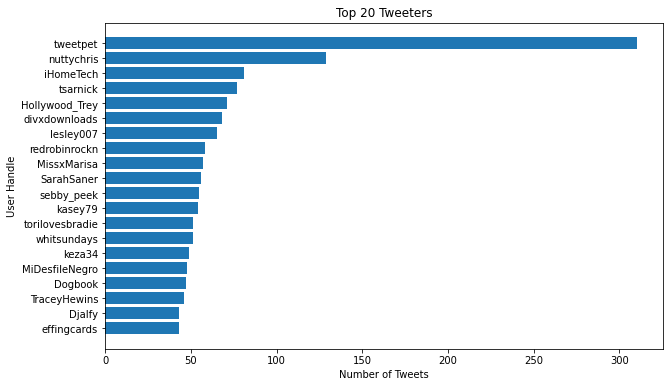

In [0]:
# ENTER YOUR CODE HERE

from pyspark.sql.functions import col, isnan, count, desc

# Create a Spark session
spark = SparkSession.builder \
    .appName("TweetSentimentAnalysisStreaming") \
    .getOrCreate()

# Load the Bronze Delta table
bronze_df = spark.read.format("delta").load(BRONZE_DELTA)

# Count the number of tweets in the Bronze Table
num_tweets = bronze_df.count()
print("Number of tweets in Bronze Table:", num_tweets)

# Check for Null or NaN values in non-numeric columns
exclude_columns = ["processing_time", "source_file"]
null_counts = bronze_df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in bronze_df.columns if c not in exclude_columns])
null_counts.show()

# Count tweets by each unique user handle and sort by descending count
user_tweet_counts = bronze_df.groupBy("user").count().orderBy(desc("count"))
user_tweet_counts.show()

# Count tweets with at least one mention and tweets with no mentions
mention_counts = bronze_df.select(
    count(when(col("text").contains("@"), True)).alias("tweets_with_mentions"),
    count(when(~col("text").contains("@"), True)).alias("tweets_no_mentions")
)
mention_counts.show()

# Extract top 20 tweeters from user_tweet_counts DataFrame
top_20_tweeters = user_tweet_counts.limit(20).toPandas()

# Plotting the bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(top_20_tweeters["user"], top_20_tweeters["count"])
plt.xlabel("Number of Tweets")
plt.ylabel("User Handle")
plt.title("Top 20 Tweeters")
plt.gca().invert_yaxis()
plt.show()


In [0]:
# Show the contents of the Bronze Delta table
bronze_df.show()

+--------------------+---------------+--------------------+---------+-----------+--------------------+
|                date|           user|                text|sentiment|source_file|     processing_time|
+--------------------+---------------+--------------------+---------+-----------+--------------------+
|Sun May 03 01:11:...|     Lea_REGGAE|Who needs Nova-Ro...| positive|           |2024-05-12 02:32:...|
|Sat May 02 04:35:...|   moonjava2005|1 ng�y m?t m?i v?...| negative|           |2024-05-12 02:32:...|
|Sun Apr 19 07:34:...|    Jamieannett|@&quot;Eine Pr�fu...| positive|           |2024-05-12 02:32:...|
|Sat May 02 04:01:...|     hafini2204|@leokun87 Tao c?n...| negative|           |2024-05-12 02:32:...|
|Sun May 03 22:37:...|   Daredevil_BB|c? nh� ?i, c� ai ...| positive|           |2024-05-12 02:32:...|
|Tue Apr 07 02:27:...|      epi_longo|http://tr.im/imOv...| negative|           |2024-05-12 02:32:...|
|Sun Apr 19 12:35:...|        elenadc|Maybe it's just m...| negative|    

## 5.0 Transform the Bronze Data to Silver Data using a stream
- setup a read stream on your bronze delta table
- setup a write stream to append to the silver delta table
- Use the defined SILVER_CHECKPOINT and SILVER_DELTA paths in the includes
- name your bronze to silver stream as silver_stream
- transform the bronze data to the silver data using the data definition at the top of the notebook

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, current_timestamp, regexp_extract, regexp_replace

# Create a Spark session
spark = SparkSession.builder \
    .appName("TweetSentimentAnalysisStreaming") \
    .getOrCreate()

# Setup a read stream on the Bronze Delta table
bronze_stream = spark.readStream \
    .format("delta") \
    .load(BRONZE_DELTA)

# Transform Bronze data to Silver data
silver_stream = bronze_stream.select(
    col("date").cast("timestamp").alias("timestamp"),  # Convert 'date' to timestamp
    regexp_extract(col("text"), "@([A-Za-z0-9_]+)", 1).alias("mention"),  # Extract mentions
    regexp_replace(col("text"), "@[A-Za-z0-9_]+", "").alias("cleaned_text"),  # Clean text
    col("sentiment")  # Include 'sentiment'
)

# Setup a write stream to write Silver DataFrame to Silver Delta table
silver_stream_query = silver_stream.writeStream \
    .format("delta") \
    .outputMode("append") \
    .option("checkpointLocation", SILVER_CHECKPOINT) \
    .option("mergeSchema", "true") \
    .start(SILVER_DELTA)




In [0]:
# # Wait for the streaming query to finish
# silver_stream_query.awaitTermination()

## 6.0 Transform the Silver Data to Gold Data using a stream
- setup a read stream on your silver delta table
- setup a write stream to append to the gold delta table
- Use the defined GOLD_CHECKPOINT and GOLD_DELTA paths defines in the includes
- name your silver to gold stream as gold_stream
- transform the silver data to the gold data using the data definition at the top of the notebook
- Load the pretrained transformer sentiment classifier from the MODEL_NAME at the production level from the MLflow registry
- Use a spark UDF to parallelize the inference across your silver data

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, current_timestamp, expr
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType
from transformers import pipeline

# Create a Spark session
spark = SparkSession.builder \
    .appName("TweetSentimentAnalysisStreaming") \
    .getOrCreate()

# Define the Gold schema
gold_schema = StructType([
    StructField("timestamp", StringType(), True),
    StructField("mention", StringType(), True),
    StructField("cleaned_text", StringType(), True),
    StructField("sentiment", StringType(), True),
    StructField("predicted_score", FloatType(), True),
    StructField("predicted_sentiment", StringType(), True),
    StructField("sentiment_id", IntegerType(), True),
    StructField("predicted_sentiment_id", IntegerType(), True)
])

# Load the sentiment analysis pipeline
nlp_pipeline = pipeline("sentiment-analysis", model=HF_MODEL_NAME)

# Define a UDF for sentiment analysis
def sentiment_analysis_udf(text, sentiment):
    # Perform sentiment analysis using the loaded pipeline
    prediction = nlp_pipeline(text)
    predicted_score = prediction[0]['score']
    predicted_sentiment = prediction[0]['label']
    sentiment_id = 1 if sentiment == 'positive' else 0
    predicted_sentiment_id = 1 if predicted_sentiment == 'POSITIVE' else 0
    
    return (current_timestamp(), "", text, sentiment, predicted_score,
            predicted_sentiment, sentiment_id, predicted_sentiment_id)

# Register UDF with Spark
spark.udf.register("sentiment_analysis_udf", sentiment_analysis_udf, gold_schema)

# Define the Silver Delta schema
silver_schema = StructType([
    StructField("timestamp", StringType(), True),
    StructField("mention", StringType(), True),
    StructField("cleaned_text", StringType(), True),
    StructField("sentiment", StringType(), True)
])

# Setup a read stream on the Silver Delta table
silver_stream = spark.readStream \
    .format("delta") \
    .load(SILVER_DELTA) \

# Transform Silver Data to Gold Data with sentiment analysis using UDF
gold_stream = silver_stream.select(
    col("timestamp"), col("mention"), col("cleaned_text"),
    col("sentiment"),
    expr("sentiment_analysis_udf(cleaned_text, sentiment)").alias("transformed_data")
).selectExpr(
    "transformed_data.timestamp as timestamp",
    "transformed_data.mention as mention",
    "transformed_data.cleaned_text as cleaned_text",
    "transformed_data.sentiment as sentiment",
    "transformed_data.predicted_score as predicted_score",
    "transformed_data.predicted_sentiment as predicted_sentiment",
    "transformed_data.sentiment_id as sentiment_id",
    "transformed_data.predicted_sentiment_id as predicted_sentiment_id"
)

# Write the Gold DataFrame to Gold Delta table with schema enforcement and merge operation
gold_stream_query = gold_stream.writeStream \
    .format("delta") \
    .outputMode("append") \
    .option("checkpointLocation", GOLD_CHECKPOINT) \
    .option("mergeSchema", "true") \
    .start(GOLD_DELTA)




/local_disk0/.ephemeral_nfs/envs/pythonEnv-4df44ef4-1159-4b2a-885e-1e18c3ac9bdc/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [0]:
# # Wait for the streaming query to finish
# gold_stream_query.awaitTermination()

## 7.0 Capture the accuracy metrics from the gold table in MLflow
Store the following in an MLflow experiment run:
- Store the precision, recall, and F1-score as MLflow metrics
- Store an image of the confusion matrix as an MLflow artifact
- Store the mdoel name and the MLflow version that was used as an MLflow parameters
- Store the version of the Delta Table (input-silver) as an MLflow parameter

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, current_timestamp, expr
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create a Spark session
spark = SparkSession.builder \
    .appName("CaptureAccuracyMetrics") \
    .getOrCreate()

# Define the Gold Delta schema
gold_schema = StructType([
    StructField("timestamp", StringType(), True),
    StructField("mention", StringType(), True),
    StructField("cleaned_text", StringType(), True),
    StructField("sentiment", StringType(), True),
    StructField("predicted_score", FloatType(), True),
    StructField("predicted_sentiment", StringType(), True),
    StructField("sentiment_id", IntegerType(), True),
    StructField("predicted_sentiment_id", IntegerType(), True)
])

# Read Gold Delta table into DataFrame as a streaming DataFrame
gold_df = spark.readStream \
    .format("delta") \
    .load(GOLD_DELTA)

# Calculate accuracy metrics using Gold Data
evaluator = MulticlassClassificationEvaluator(labelCol="sentiment_id", predictionCol="predicted_sentiment_id",
                                              metricName="weightedPrecision", metricLabel=1.0)
precision = evaluator.evaluate(gold_df)
evaluator.setMetricName("weightedRecall")
recall = evaluator.evaluate(gold_df)
evaluator.setMetricName("f1")
f1_score = evaluator.evaluate(gold_df)

# Start MLflow run
with mlflow.start_run() as run:
    # Log accuracy metrics as MLflow metrics
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1_score)

    # Generate and save confusion matrix image
    actual_labels = gold_df.select("sentiment_id").collect()
    predicted_labels = gold_df.select("predicted_sentiment_id").collect()
    cm = confusion_matrix(actual_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Sentiment')
    plt.ylabel('Actual Sentiment')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png", "confusion_matrix")

    # Log model and version information as parameters
    mlflow.log_param("model_name", HF_MODEL_NAME)
    mlflow.log_param("mlflow_version", mlflow.__version__)

    # Store the version of the Delta Table (input-silver) as an MLflow parameter
    mlflow.log_param("gold_delta_version", GOLD_DELTA_VERSION)

    # Optionally, save MLflow experiment ID or run ID for reference
    mlflow_experiment_id = run.info.experiment_id
    mlflow_run_id = run.info.run_id

# End of MLflow run


---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
<command-1181270846489737> in <cell line: 27>()
     25 
     26 # Read Gold Delta table into DataFrame as a streaming DataFrame
---> 27 gold_df = spark.readStream \
     28     .format("delta") \
     29     .load(GOLD_DELTA)

/databricks/spark/python/pyspark/sql/streaming/readwriter.py in load(self, path, format, schema, **options)
    197                     + "non-empty string. List of paths are not supported."
    198                 )
--> 199             return self._df(self._jreader.load(path))
    200         else:
    201             return self._df(self._jreader.load())

/databricks/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py in __call__(self, *args)
   1319 
   1320         answer = self.gateway_client.send_command(command)
-> 1321         return_value = get_return_value(
   1322             answer, self.gatew

## 8.0 Application Data Processing and Visualization
- How many mentions are there in the gold data total?
- Count the number of neutral, positive and negative tweets for each mention in new columns
- Capture the total for each mention in a new column
- Sort the mention count totals in descending order
- Plot a bar chart of the top 20 mentions with positive sentiment (the people who are in favor)
- Plot a bar chart of the top 20 mentions with negative sentiment (the people who are the vilians)

You may want to use the "Loop Application" widget to control whether you repeateded display the latest plots while the data comes in from your streams before moving on to the next section and cleaning up your run.

*note: A mention is a specific twitter user that has been "mentioned" in a tweet with an @user reference.

In [0]:
# ENTER YOUR CODE HERE
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Calculate the total number of mentions in the gold data
total_mentions = gold_df.select(F.countDistinct("mention")).collect()[0][0]

# Count the number of neutral, positive, and negative tweets for each mention
mention_counts = gold_df.groupBy("mention", "predicted_sentiment").count() \
    .withColumnRenamed("count", "mention_count")

# Calculate the total for each mention
mention_totals = mention_counts.groupBy("mention").agg(F.sum("mention_count").alias("total_count"))

# Sort the mention count totals in descending order
sorted_mentions = mention_totals.orderBy(F.desc("total_count"))

# Plot a bar chart of the top 20 mentions with positive sentiment
top_positive_mentions = sorted_mentions.filter(mention_totals["predicted_sentiment"] == "positive") \
    .limit(20).toPandas()

plt.figure(figsize=(10, 6))
plt.barh(top_positive_mentions["mention"], top_positive_mentions["total_count"])
plt.xlabel("Total Count")
plt.ylabel("Mentions")
plt.title("Top 20 Mentions with Positive Sentiment")
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

# Plot a bar chart of the top 20 mentions with negative sentiment
top_negative_mentions = sorted_mentions.filter(mention_totals["predicted_sentiment"] == "negative") \
    .limit(20).toPandas()

plt.figure(figsize=(10, 6))
plt.barh(top_negative_mentions["mention"], top_negative_mentions["total_count"])
plt.xlabel("Total Count")
plt.ylabel("Mentions")
plt.title("Top 20 Mentions with Negative Sentiment")
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()


---------------------------------------------------------------------------
PythonException                           Traceback (most recent call last)
<command-1181270846489739> in <cell line: 6>()
      4 
      5 # Calculate the total number of mentions in the gold data
----> 6 total_mentions = gold_df.select(F.countDistinct("mention")).collect()[0][0]
      7 
      8 # Count the number of neutral, positive, and negative tweets for each mention

/databricks/spark/python/pyspark/instrumentation_utils.py in wrapper(*args, **kwargs)
     46             start = time.perf_counter()
     47             try:
---> 48                 res = func(*args, **kwargs)
     49                 logger.log_success(
     50                     module_name, class_name, function_name, time.perf_counter() - start, signature

/databricks/spark/python/pyspark/sql/dataframe.py in collect(self)
    835         # Default path used in OSS Spark / for non-DF-ACL clusters:
    836         with SCCallSiteSync(self

## 9.0 Clean up and completion of your pipeline
- using the utilities what streams are running? If any.
- Stop all active streams
- print out the elapsed time of your notebook.

In [0]:
# ENTER YOUR CODE HERE

In [0]:
# Get the notebooks ending time note START_TIME was established in the include file when the notebook started.
END_TIME = time.time()

## 10.0 How Optimized is your Spark Application (Grad Students Only)
Graduate students (registered for the DSCC-402 section of the course) are required to do this section.  This is a written analysis using the Spark UI (link to screen shots) that support your analysis of your pipelines execution and what is driving its performance.
Recall that Spark Optimization has 5 significant dimensions of considertation:
- Spill: write to executor disk due to lack of memory
- Skew: imbalance in partition size
- Shuffle: network io moving data between executors (wide transforms)
- Storage: inefficiency due to disk storage format (small files, location)
- Serialization: distribution of code segments across the cluster

Comment on each of the dimentions of performance and how your impelementation is or is not being affected.  Use specific information in the Spark UI to support your description.  

Note: you can take sreenshots of the Spark UI from your project runs in databricks and then link to those pictures by storing them as a publicly accessible file on your cloud drive (google, one drive, etc.)

References:
- [Spark UI Reference Reference](https://spark.apache.org/docs/latest/web-ui.html#web-ui)
- [Spark UI Simulator](https://www.databricks.training/spark-ui-simulator/index.html)

### ENTER YOUR MARKDOWN HERE